# Homework 2: Predicting Housing Prices

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import os
from subprocess import call, check_output
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew,norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


#call(['unzip','all.zip'])

os.listdir()

['test.csv.gz',
 'sample_submission.csv.gz',
 'test.csv',
 'submission.csv',
 'data_description.txt',
 'all.zip',
 'trial_submission.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'hw2.ipynb',
 'train.csv.gz',
 'sample_submission.csv']

## Data Cleaning

I'm going to read in both train and test and combine them for cleaning purposes.

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
houses = pd.concat([train, test])

Here are some quick and messy looks at our data. This gives us an initial sense of the values in the data.

In [3]:
houses.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


Before we continue describing the data, we should drop Id before we forget and accidentally use it for prediction.

In [4]:
houses.drop(['Id'], axis=1, inplace=True)
houses.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2917.000000,2917.000000,2918.000000,2919.000000,...,2919.000000,2919.000000,1460.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.423235,49.582248,0.429894,0.061364,560.772104,23.098321,...,6.089072,2.251799,180921.195890,16.062350,6.451524,1051.777587,93.709832,1971.312778,1984.264474,2007.792737
std,392.362079,428.701456,25.188169,0.822693,455.610826,169.205611,0.524736,0.245687,439.543659,64.244246,...,1.409947,35.663946,79442.502883,56.184365,1.569379,440.766258,126.526589,30.291442,20.894344,1.314964
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,5.000000,0.000000,129975.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.500000,0.000000,0.000000,0.000000,467.000000,0.000000,...,6.000000,0.000000,163000.000000,0.000000,6.000000,989.500000,0.000000,1973.000000,1993.000000,2008.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.500000,0.000000,...,7.000000,0.000000,214000.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,10.000000,800.000000,755000.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000,2010.000000


In [5]:
houses.corr()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1stFlrSF,1.000000,-0.249823,0.044086,0.108418,0.458092,0.084330,0.261816,0.011074,0.296600,-0.065796,...,0.479152,0.121900,0.605852,0.098381,0.391782,0.801670,0.227347,0.310814,0.242245,-0.013442
2ndFlrSF,-0.249823,1.000000,-0.032458,0.503506,-0.162301,-0.097744,-0.161468,-0.060282,-0.000376,0.054645,...,0.245596,0.044503,0.319334,0.011070,0.584586,-0.205665,0.089922,0.017588,0.158985,-0.019229
3SsnPorch,0.044086,-0.032458,1.000000,-0.048279,0.050908,-0.023279,0.027378,0.026861,-0.005810,-0.032822,...,0.018715,-0.006525,0.044584,-0.029546,-0.025764,0.037892,-0.003935,0.015958,0.037433,0.022560
BedroomAbvGr,0.108418,0.503506,-0.048279,1.000000,-0.113547,-0.031223,-0.155200,0.018848,0.183259,0.049940,...,0.073075,0.036544,0.168213,0.007254,0.669737,0.053393,0.031644,-0.053101,-0.021912,-0.020453
BsmtFinSF1,0.458092,-0.162301,0.050908,-0.113547,1.000000,-0.055045,0.638847,0.078361,-0.477404,-0.099712,...,0.281810,0.084462,0.386420,0.096823,0.052141,0.536467,0.223492,0.279581,0.152126,0.022556
BsmtFinSF2,0.084330,-0.097744,-0.023279,-0.031223,-0.055045,1.000000,0.162835,0.099485,-0.238241,0.032740,...,-0.042771,0.044524,-0.011378,0.063302,-0.048423,0.089410,0.098399,-0.027595,-0.062153,0.008883
BsmtFullBath,0.261816,-0.161468,0.027378,-0.155200,0.638847,0.162835,1.000000,-0.148832,-0.398678,-0.068393,...,0.164543,0.043970,0.227122,0.053119,-0.038916,0.325623,0.186107,0.211580,0.134947,0.045255
BsmtHalfBath,0.011074,-0.060282,0.026861,0.018848,0.078361,0.099485,-0.148832,1.000000,-0.107121,-0.009675,...,-0.040732,0.066851,-0.016844,0.042069,-0.049610,0.012396,0.051549,-0.030282,-0.046285,-0.020028
BsmtUnfSF,0.296600,-0.000376,-0.005810,0.183259,-0.477404,-0.238241,-0.398678,-0.107121,1.000000,0.005006,...,0.275175,-0.032273,0.214479,-0.049158,0.247505,0.412285,-0.039302,0.130473,0.165175,-0.038015
EnclosedPorch,-0.065796,0.054645,-0.032822,0.049940,-0.099712,0.032740,-0.068393,-0.009675,0.005006,1.000000,...,-0.139256,0.092534,-0.128578,-0.064377,0.015345,-0.085510,-0.119114,-0.374073,-0.220456,-0.001134


In [6]:
houses.corr().SalePrice.sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

It looks like the most important features are the amount of living area and the overall quality. This may change as we actually create the dummy variables.

### Missing Values

We're first going to see which values are missing.

In [7]:
print('observations', houses.shape[0], '\n')

def missing_values(df):
    #Print out missing values sorted from high to low.
    missingDict = {}
    for var in df.columns:
        missingDict[var] = df[df[var].isnull()].shape[0]

    return pd.Series(missingDict).sort_values(ascending=False)

print('Missing Values')
missing_values(houses)

observations 2919 

Missing Values


PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageCond        159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
Electrical          1
Exterior2nd         1
KitchenQual         1
GarageCars          1
Exterior1st         1
GarageArea          1
                 ... 
GrLivArea           0
YearRemodAdd        0
YearBuilt           0
WoodDeckSF          0
TotRmsAbvGrd        0
Street              0
ScreenPorch         0
SaleCondition       0
RoofStyle           0
RoofMatl            0
PoolArea            0
PavedDrive          0
OverallQual         0
OverallCond         0
OpenPorchS

There are quite a few missing values. Luckily, data_description.txt states what some of those values should be. The missing SalePrice is from the test set, so we can ignore that for cleaning. For some numeric types, they are missing because that room or element of the house does not exist, so we'll set the numeric type to zero. Finally, there are some missing values that we will change to other.

In [8]:
def clean_NA(df, varList, replacementValue):
    for var in varList:
        df[var].fillna(replacementValue, inplace=True)
    return 0

changeToNone = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',\
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType',\
                'GarageYrBlt', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Electrical']
changeToZero = ['GarageCars', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',  \
                'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath']
changeToOth = ['SaleType', 'Exterior1st', 'Exterior2nd']
varLists = [changeToNone, changeToZero, changeToOth]
replacementValues = ['None', 0, 'Oth']
for params in zip(varLists, replacementValues):
    clean_NA(houses, params[0], params[1])

missing_values(houses)

SalePrice        1459
LotFrontage       486
Foundation          0
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
Fence               0
FireplaceQu         0
Fireplaces          0
YrSold              0
Electrical          0
FullBath            0
Functional          0
GarageArea          0
GarageCars          0
GarageCond          0
GarageFinish        0
GarageQual          0
GarageType          0
EnclosedPorch       0
Condition2          0
GrLivArea           0
BsmtFinSF1          0
2ndFlrSF            0
3SsnPorch           0
Alley               0
BedroomAbvGr        0
BldgType            0
BsmtCond            0
                 ... 
RoofStyle           0
SaleType            0
Heating             0
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
TotalBsmtSF         0
Utilities           0
WoodDeckSF          0
YearBuilt           0
OpenPorchSF         0
Neighborhood        0
MoSold              0
MiscVal             0
HeatingQC 

We also need to change LotFrontage, but the documentation has no clue as to why this is missing. We'll impute it after fixing a couple other things. Next, let's look at the sale price and compare it to a norm distribution.

### Dummy Variables and Re-scaling

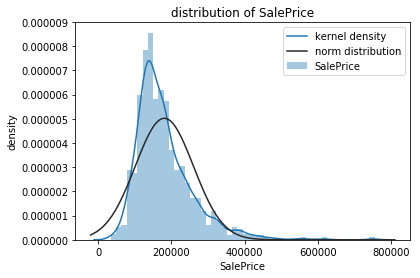

In [9]:
def distplot(var):
    sns.distplot(houses.loc[~houses[var].isnull(),var], bins=50, fit=norm, axlabel=var, label=var, fit_kws={'label': 'norm distribution'}, kde_kws={'label': 'kernel density'})
    plt.ylabel('density')
    plt.legend()
    plt.title('distribution of {}'.format(var))

distplot('SalePrice')

This is quite skewed even without checkiing the skew. Let's take the log and see if it fixes it.

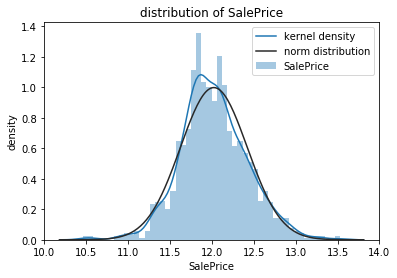

In [10]:
houses.SalePrice = np.log(houses.SalePrice)
distplot('SalePrice')

Beautiful! Not perfect, but much better than before.

After noting that the sale price is skewed, I'm going to fix the other numeric variables for skewness. I noticed quite a few kernels using box cox, so I follow a lot of their queues. I define dummy variables so I don't accidentally change those values. Specifically see https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [11]:
qual_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
houses.ExterQual = houses.ExterQual.replace(qual_dict)
houses.ExterCond = houses.ExterCond.replace(qual_dict)

dummy_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',\
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',\
              'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'KitchenQual',\
              'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',\
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', \
              'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',\
              'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'GarageYrBlt']
numeric_feats = list(set(houses.columns) - set(dummy_list))
skewness = houses[numeric_feats].skew(axis=0).sort_values()
skewness

YearBuilt        -0.600114
YearRemodAdd     -0.451252
GarageCars       -0.219694
SalePrice         0.121335
FullBath          0.167692
OverallQual       0.197212
GarageArea        0.239380
BedroomAbvGr      0.326492
OverallCond       0.570605
BsmtFullBath      0.625153
HalfBath          0.694924
Fireplaces        0.733872
TotRmsAbvGrd      0.758757
ExterQual         0.786786
2ndFlrSF          0.862118
BsmtUnfSF         0.919812
TotalBsmtSF       1.157489
GrLivArea         1.270010
ExterCond         1.316590
BsmtFinSF1        1.425963
1stFlrSF          1.470360
LotFrontage       1.503278
WoodDeckSF        1.843380
OpenPorchSF       2.536417
MasVnrArea        2.614936
BsmtHalfBath      3.933616
ScreenPorch       3.948723
EnclosedPorch     4.005950
BsmtFinSF2        4.148275
KitchenAbvGr      4.304467
3SsnPorch        11.381914
LowQualFinSF     12.094977
LotArea          12.829025
PoolArea         16.907017
MiscVal          21.958480
dtype: float64

I'm not extremely familiar with Box Cox, so I used most of the kernel's code here. Since fixing skewness wasn't really taught in class, I assume it's fine to use the general structure of his code. From what I understand, Box Cox transformation is a generalization of taking the log transformation of a variable. From the scipy documentation, the equation is y = (x^lmbda - 1) / lmbda. In our case, lmbda is lam. If I wasn't allowed to use the kernel's code here, just pretend it doesn't exist and that I took a log transformation of some of the numeric variables.

In [12]:
from scipy.special import boxcox1p
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if feat != 'SalePrice':
        houses[feat] = boxcox1p(houses[feat], lam)

There are 23 skewed numerical features to Box Cox transform


Now I'm going to do the last transformations of variables. This includes scaling data and creating dummies. Also, I'm adding a dummy for if it's been remodeled since that is a different dimension than years since the last remodel. The year variable should often be functions of the year sold since the value is more in the age of the house instead of the specific year that it was built. However, I'm keeping garage year built as a dummy since that value can be none when there is no garage and can't be imputed.

In [13]:
#New variables
houses['isRemodeled'] = houses['YearRemodAdd'] != houses['YearBuilt']
houses['YearBuilt'] = houses['YrSold'] - houses['YearBuilt']
houses['YearRemodAdd'] = houses['YrSold'] - houses['YearRemodAdd']

#scale data
train = houses.loc[~houses.SalePrice.isnull(), :]
test  = houses.loc[houses.SalePrice.isnull(), :] #Test needs to be transformed but not used as fit for scaling.

tmp_list = dummy_list.copy()
tmp_list.extend(['LotFrontage', 'SalePrice'])
standard = StandardScaler()
tmp = train.drop(tmp_list, axis=1)
tmp_test = test.drop(tmp_list, axis=1)
houses.reset_index(drop=True, inplace=True)
train_standard = pd.DataFrame(standard.fit_transform(tmp), columns=tmp.columns)
test_standard = pd.DataFrame(standard.transform(tmp_test), columns=tmp_test.columns)
houses_standard = pd.concat([train_standard, test_standard])
houses_standard.reset_index(drop=True, inplace=True)
houses_standard = pd.concat([houses_standard, houses[tmp_list]], axis=1)

def create_dummies(columnName, df):
    dummy_temp = pd.get_dummies(df[columnName])
    dummy_temp.columns = [columnName + '_' + str(i) for i in dummy_temp.columns]
    df = pd.concat([df, dummy_temp], axis=1)
    df.drop([columnName], axis=1, inplace=True)
    return df

for var in dummy_list:
    houses_standard = create_dummies(var, houses_standard)

### Returning to Lot Frontage

Now we return to the last missing variable, lot frontage. Lot frontage is the feet of street connected to property. I saw many kernels fill this with the median, but I think that K nearest neighbors is a better method. K nearest neighbors uses a distance metric to find a fixed number of points that are closest to the chosen observation. Then, to predict a continuous variable, it takes some weighted average of the neighbors.

High dimensionality is a problem for this model. Fortunately, other variables somewhat determine the variable we are trying to predict. Lot frontage is obviously affected by the configuration of the lot and the size of the lot. The houses with the same lot configuration and same lot size should be an accurate predictor for the lot frontage of the missing values. Let's look at lot frontage more closely to make sure this is true.

Here's the correlations with LotFrontage.

In [14]:
houses_standard.corr().LotFrontage.sort_values()

MSSubClass_160         -0.552530
BldgType_Twnhs         -0.525952
BldgType_TwnhsE        -0.398613
MSZoning_RM            -0.382431
Neighborhood_BrDale    -0.327728
Neighborhood_MeadowV   -0.304837
MSSubClass_120         -0.301962
GarageType_Detchd      -0.263934
FireplaceQu_None       -0.223128
Neighborhood_NPkVill   -0.221662
Alley_Pave             -0.209936
MSSubClass_180         -0.204556
Exterior2nd_Brk Cmn    -0.200697
RoofStyle_Gable        -0.191885
GarageFinish_Unf       -0.175934
GarageYrBlt_1973.0     -0.164732
BsmtExposure_No        -0.159116
Exterior1st_CemntBd    -0.158643
Neighborhood_Blueste   -0.153288
Exterior2nd_CmentBd    -0.151564
LotShape_Reg           -0.149482
MasVnrType_None        -0.144819
LotConfig_Inside       -0.140307
KitchenQual_TA         -0.138135
Exterior1st_MetalSd    -0.128207
Exterior2nd_MetalSd    -0.127218
MSZoning_FV            -0.121994
GarageYrBlt_1972.0     -0.121720
LotConfig_CulDSac      -0.113713
Foundation_BrkTil      -0.108776
          

The variables that I thought made intuitive sense are truly correlated with lot frontage. There's some other ones as well like garage area. I actually tried garage area, and the model was extremely prone to overfitting. We'll just use those to keep the dimensionality down. High dimensionality will cause overfitting problems for our K nearest neighbors regression.

We'll be using a grid search over possible neighbor values (how many nearest neighbors to grab), weights (weight all equally or favor those closer), and different metrics (p signifies l1, l2, etc. norm).

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

predictorVars = ['LotArea', 'LotConfig_Inside', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3']
neededValues = houses_standard.loc[houses_standard['LotFrontage'].isnull(),predictorVars]
target = houses_standard.loc[~houses_standard['LotFrontage'].isnull(),'LotFrontage']
X = houses_standard.loc[~houses_standard['LotFrontage'].isnull(),predictorVars]
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, random_state=42)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(np.sqrt(mean_squared_error(y_train, y_pred_train)),
                                           np.sqrt(mean_squared_error(y_test, y_pred_test))))


Best Params: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Train MSE: 0.34254175340986953	Test MSE: 0.3958142827229603


The MSE's are okay. It's not too concerning since this is not the variable that we are primarily interested in. It will most likely be better than the median. Further tinkering might introduce overfitting, so we'll keep it as is.

In [16]:
predValues = gridsearch.predict(neededValues)
houses_standard.loc[houses_standard.LotFrontage.isnull(),'LotFrontage'] = predValues

Now I need to scale lot frontage since I skipped it earlier due to the missing values.

In [17]:
train = houses_standard.loc[~houses_standard.SalePrice.isnull(), :]
test  = houses_standard.loc[houses_standard.SalePrice.isnull(), :]

In [18]:
standard = StandardScaler()
trainLotFrontage = standard.fit_transform(train.LotFrontage.values.reshape(-1,1))
train.drop(['LotFrontage'], axis=1, inplace=True)
train.loc[:,'LotFrontage'] = trainLotFrontage
testLotFrontage = standard.transform(test.LotFrontage.values.reshape(-1,1))
test.drop(['LotFrontage'], axis=1, inplace=True)
test.loc[:,'LotFrontage'] = testLotFrontage

### Fix Outliers

We're going to look at some of the variables with the highest correlation with sale price to look for outliers. First, overall quality.

Text(0.5,1,'quality and sale price relationship')

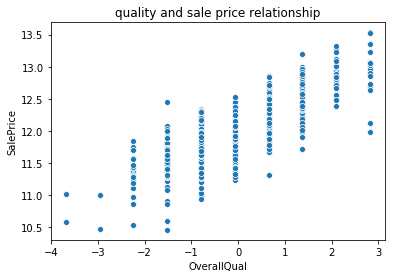

In [19]:
sns.scatterplot(x='OverallQual', y='SalePrice', data=train)
plt.title('quality and sale price relationship')

This all looks fine. There's some outliers near lower quality, but the prices are not too abnormal. Next, living area.

Text(0.5,1,'relationship between sale price and living area')

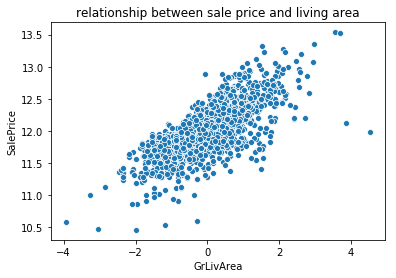

In [20]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.title('relationship between sale price and living area')

There's about four points to the right that are outliers from the rest. A couple of them also do not match the overall upward trend of the data, so they'll attenuate our results. Let's toss all of them since some kernels say the original documentation says to toss them.

In [21]:
train = train.loc[train['GrLivArea'] < 3.5, :]

I'll look at a couple more variables that are highly correlated with sale price.

Text(0.5,1,'relationship between garage cars and sale price')

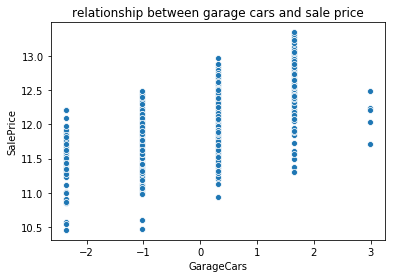

In [22]:
sns.scatterplot(x='GarageCars', y='SalePrice', data=train)
plt.title('relationship between garage cars and sale price')

There's an argument either way as to whether I should drop the right tail of garage capacity. It looks like there is an upward trend in sale price with an increase in the number of garages. Including the right tail will attenuate the coefficients if that upward trend continues, but an abnormal garage capacity may hurt the price of a house. We'll keep them just to be safe. Now I'll examine sale price by itself.

Text(0.5,1,'Box Plot of Sale Price')

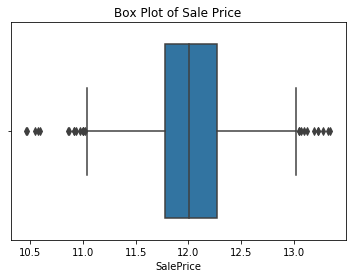

In [23]:
sns.boxplot(train.SalePrice)
plt.title('Box Plot of Sale Price')

The left tail is fairly separated from the rest of the observations. They appear separated from the rest in GrLivArea as well, so I'll toss them.

In [24]:
train = train.loc[train['SalePrice'] > 10.60, :]

## Models

### Simple Gradient Descent

We're not going to do anything fancy with this model. This is going to be a benchmark for the rest of our models since they should be able to beat a simple gradient descent. Selecting hyperparameters isn't a huge deal for gradient descent, so we'll forgo a grid search for this first one to keep things simple.

In the end, this model will produce a prediction that is a linear combination of our other variables. It does this by minimizing the mean squared error. While more traditional methods do this with the normal equation, gradient descent uses a computational approximation of the minimization. Given an initial learning rate and a tolerance, it uses the learning rate to determine the step size along the MSE curve, and the tolerance dictates when to stop iterating based on the reduction in the cost function.

First, we break up the data set into train and test sets. We'll use a test size of 0.2 since it's common and our training sample isn't extremely large for something like gradient descent.

In [25]:
#Train test split
SalePrice = train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train, SalePrice, test_size=0.2)

In [26]:
model = SGDRegressor(tol=0.0001, eta0=0.01)
model.fit(Xtrain, Ytrain)
trainPred = model.predict(Xtrain)
testPred = model.predict(Xtest)

def output_mse(y_train, y_test, train_pred, test_pred):
    trainMSE = mean_squared_error(y_train, train_pred)
    testMSE  = mean_squared_error(y_test, test_pred)

    print("Train RMSE: {}".format(np.sqrt(trainMSE)))
    print("Test RMSE: {}".format(np.sqrt(testMSE)))

output_mse(Ytrain, Ytest, trainPred, testPred)

Train RMSE: 0.14478713523023448
Test RMSE: 0.17657362302971252


Now let's introduce a grid search to the previous model. This grid search chooses the best learning rate for the gradient descent. We use the ones suggested by Andrew Ng like in the lecture notebook.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}
linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring='neg_mean_squared_error')
random_search.fit(Xtrain, Ytrain)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.03}
Best Negative MSE: -0.04190148304569983


The learning rate was different from our initially chosen learning rate. Let's see how that impacted the test MSE.

In [28]:
trainPred = random_search.predict(Xtrain)
testPred  = random_search.predict(Xtest)

output_mse(Ytrain, Ytest, trainPred, testPred)

Train RMSE: 0.125483909721265
Test RMSE: 0.15888928846630873


The mean squared error is essentially a measure of the distance between the predicted value and the actual value. This distance is squared, summed, and divided by the sample size. Taking the square root of this value makes it more interpretable, but it's not necessary. For this model, the cross validation helped choose hyperparameters that improved the MSE. However, notice that our training RMSE is smaller than the test RMSE. This implies that this gradient descent model is overfitting. It is likely doing this because of the sheer number of variables that are included in the model. This is unfortunate because the model could use polynomial variables. To reduce the number of variables, I could drop the garage year built since that should be a numeric variable but was transformed into a dummy to fix the missing values. To fix this, I can also use elastic net to reduce the size of coefficients of less predictive variables.

## Elastic Net

This model fights against overfitting by prioritizing the most predictive variables. Elastic net is essentially a combination of lasso and ridge regressions. The l1_ratio hyperparameter chooses whether elastic net is more like lasso or ridge. If 1, it is lasso. If 0, it is ridge. The closer to lasso, the more likely the model will force coefficients to zero because it uses closer to the absolute value of the coefficients as a penalty. Ridge uses the squared values of the coefficients. The alpha parameter controls for the penalization of large coefficients. The larger the alpha, the larger the penalty. By penalizing large coefficients, this will hopefully fix our overfitting from the last model. We omit an explicit alpha and let n_alphas=100 parameter handle the alpha grid.

In [29]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train, SalePrice, test_size=0.2)
clf = ElasticNetCV(l1_ratio=[.01, .1, .3, .5, .7, .9, .95, .99, 1])
clf.fit(Xtrain, Ytrain)
train_predictions = clf.predict(Xtrain)
test_predictions = clf.predict(Xtest)
output_mse(Ytrain, Ytest, train_predictions, test_predictions)

Train RMSE: 0.09425870186581572
Test RMSE: 0.10885358018182625


In [30]:
print(clf.l1_ratio_)
clf.alpha_

1.0


0.0006833674246137729

It did fix the overfitting quite a bit! It also improved the RMSE for both the train and test sets. This is clearly a better model than the simple gradient descent. The l1 ratio shows that it was a pure lasso regression, and the alpha was very close to zero. The only issue with this model now would be high bias. This is harder to identify. We can add polynomial variables to the regression to see if it helps, but we have to be careful with overfitting. Overall, this model is fairly predictive. This is a safe model for making business decisions since there is relatively no overfitting, yet the MSE is fairly small, meaning the predictions are fairly accurate.

In [31]:
#Submission prep
test.drop(['SalePrice'], inplace=True, axis=1)
scores = clf.predict(test)
ids = pd.read_csv('test.csv', usecols=['Id'])
scores = pd.concat([ids, pd.Series(scores)], axis=1)
scores.columns = ['Id', 'SalePrice']
scores['SalePrice'] = np.exp(scores.SalePrice)
scores.to_csv('submission.csv', index=None)

### Adding Polynomial Regressors

Now we add some polynomial features to see if they cause overfitting or if they improve the MSE all around. Polynomial features introduce higher complexity by allowing more complicated relationships to be expressed in the model. However, this can cause the line to fit too closely to the training data, so care is needed.

In [32]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)
poly_train = poly.fit_transform(train)
poly_train_scaled = standard.fit_transform(poly_train)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(poly_train_scaled, SalePrice, test_size=0.2)
print('number of columns: {}'.format(Xtrain.shape[1]))

number of columns: 95702


That's a lot of variables! The number of columns blows up because we are adding interactions between all of our variables. It would make more sense to choose a few values to add polynomial features as opposed to the whole model. I'm going to use some of the more prominent numerical features.

In [33]:
poly_cols = ['GrLivArea', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'YearBuilt', 'OverallCond', 'OverallQual', 'LotArea', 'LotFrontage']
poly_train = pd.DataFrame(poly.fit_transform(train[poly_cols]))
poly_train.reset_index(drop=True, inplace=True)
tmp_train = train.drop(poly_cols, axis=1)
tmp_train.reset_index(drop=True, inplace=True)
poly_train = pd.concat([tmp_train, poly_train], axis=1)
poly_train_scaled = standard.fit_transform(poly_train)
#TODO create poly_test_scaled
poly_test = pd.DataFrame(poly.fit_transform(test[poly_cols]))
poly_test.reset_index(drop=True, inplace=True)
tmp_test = test.drop(poly_cols, axis=1)
tmp_test.reset_index(drop=True, inplace=True)
poly_test = pd.concat([tmp_test, poly_test], axis=1)
poly_test_scaled = standard.transform(poly_test)
Xtrain2, Xtest2, Ytrain2, Ytest2 = train_test_split(poly_train_scaled, SalePrice, test_size=0.2)

In [34]:
clf2 = ElasticNetCV(l1_ratio=[.01, .1, .3, .5, .7, .9, .95, .99, 1])
clf2.fit(Xtrain2, Ytrain2)
train_predictions = clf2.predict(Xtrain2)
test_predictions = clf2.predict(Xtest2)
output_mse(Ytrain2, Ytest2, train_predictions, test_predictions)

Train RMSE: 0.09229511285347311
Test RMSE: 0.11259208194286893


The model is essentially the same. Let's submit it and see if it improves on the test set.

In [35]:
scores = clf2.predict(poly_test_scaled)
scores = pd.concat([ids, pd.Series(scores)], axis=1)
scores.columns = ['Id', 'SalePrice']
scores['SalePrice'] = np.exp(scores.SalePrice)
scores.to_csv('trial_submission.csv', index=None)

Indeed, the submission is slightly better with polynomials, but not by much. Some additional polynomials may improve the results even further, but we obviously don't want to fit a model where the number of variables is almost 100x greater than the number of observations.

### A discussion of K nearest neighbors

K nearest neighbors is not amazing for this model. There is high dimensionality compared to the number of observations. Therefore, I'll opt not to use this model for final predictions. See the predictions for lot frontage for a demonstration of how to use it.